In [4]:
from scipy import fftpack
from scipy.constants import epsilon_0
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
% matplotlib inline
from SimPEG.Utils import ndgrid, mkvc
from ipywidgets import *

# Create a Alternative Voltage Signal

In [5]:
defsignal = lambda A,f,phi,t: A*np.cos(2*np.pi*f*t+phi)

In [6]:
deftime = lambda start,end,dis: np.linspace(start,end,dis)

<function matplotlib.pyplot.tight_layout>

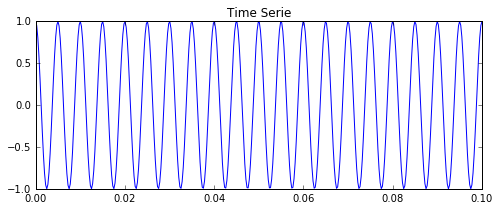

In [8]:
t=deftime(0.,0.1,400)
signal=defsignal(1,200,0.,t)

fig, ax = plt.subplots(1,1,figsize=(8,3))

ax.plot(t,signal)
ax.set_xlim([t.min(),t.max()])
ax.set_title('Time Serie')

plt.tight_layout


# Increasing sampling -> Reduce the error on Imaginary (and Real) part, increase the frequency range

<function __main__.WidgetSamplingEffect>

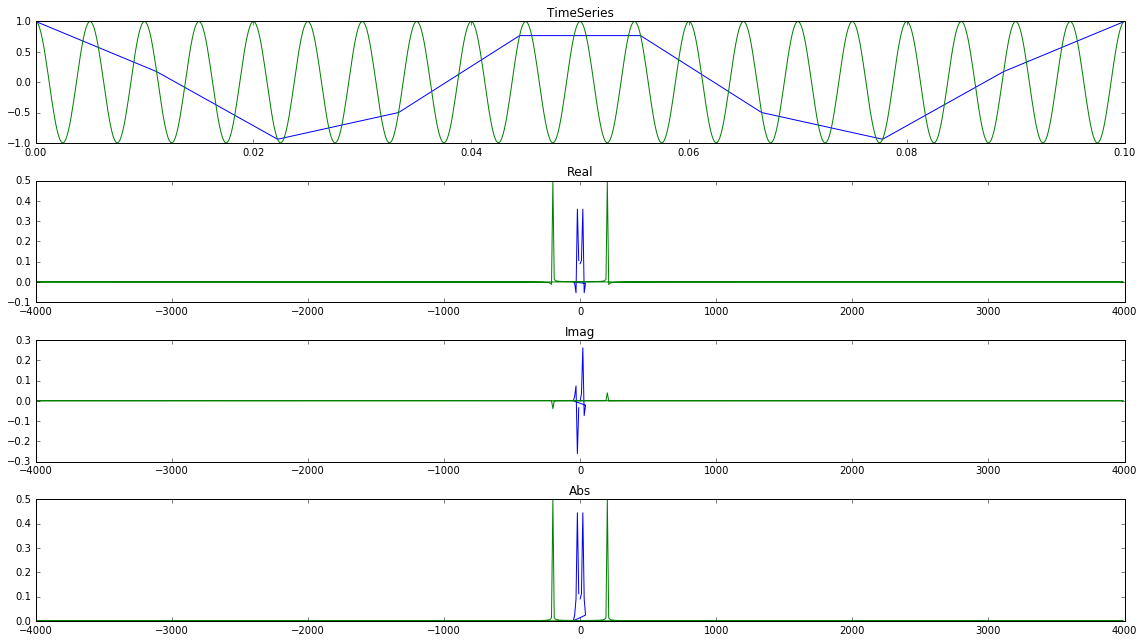

In [19]:
Discretization = FloatSlider(min=1.,max=10.,step=0.5,value=1.) #exponential increase of the number of signal samples
start = 0.
end = 0.1
Amp = 1.
NampR = 1
fs = 200.
fn = 60.
phin = np.pi/2

def WidgetSamplingEffect(dis):
    
    dis2=int(10.**dis)
    t=deftime(start,end,dis2)
    dt = (t.max() - t.min())/float(t.size)
    freq = fftpack.fftfreq(t.size,dt)
    df = (freq.max() - freq.min())/float(freq.size)
    signal=defsignal(Amp,fs,0.,t)
    Signal = dt*df*fftpack.fft(signal)
    
    t0 = np.linspace(0.,0.1,int(4.*fs))
    dt0 = (t0.max() - t0.min())/float(t0.size)
    freq0 = fftpack.fftfreq(t0.size,dt0)
    df0 = (freq0.max() - freq0.min())/float(freq0.size)
    signal0=defsignal(Amp,fs,0,t0)
    Signal0 = dt0*df0*fftpack.fft(signal0)
    
    
    fig, ax = plt.subplots(4,1,figsize=(16,9))
    ax = mkvc(ax)
    
    ax[0].plot(t,signal)
    ax[0].plot(t0,signal0)
    ax[0].set_xlim([t.min(), t.max()])
    ax[0].set_title('TimeSeries')
    
    ax[1].plot(freq,Signal.real)
    ax[1].plot(freq0,Signal0.real)
    ax[1].set_title('Real')

    ax[2].plot(freq,Signal.imag)
    ax[2].plot(freq0,Signal0.imag)
    ax[2].set_title('Imag')

    ax[3].plot(freq,np.abs(Signal))
    ax[3].plot(freq0,np.abs(Signal0))
    ax[3].set_title('Abs')
    
                  
    plt.tight_layout()


interact(WidgetSamplingEffect,dis=Discretization)

# 60Hz noise

In [10]:
#Remove a particular frequency from a spectrum
def RemoveFreqFilter(f0,freq,Signal):
    SignalFilt=np.zeros(shape=len(Signal),dtype=np.complex_)
    SignalFilt.real=Signal.real
    SignalFilt.imag=Signal.imag
    for i in np.arange(0,len(freq),1): 
        if freq[i]==f0 or freq[i]==-f0:
            SignalFilt[i]=0.+0.j
        else:
            SignalFilt[i]=Signal[i]
            
    return SignalFilt
    

In [11]:
#Keep a particular frequency from a spectrum
def KeepFreqFilter(f0,freq,Signal):
    SignalFilt=np.zeros(shape=len(Signal),dtype=np.complex_)
    SignalFilt.real=Signal.real
    SignalFilt.imag=Signal.imag
    for i in np.arange(0,len(freq),1): 
        if freq[i]==f0 or freq[i]==-f0:
            SignalFilt[i]=Signal[i]
        else:
            SignalFilt[i]=0.+0.j
            
    return SignalFilt
    

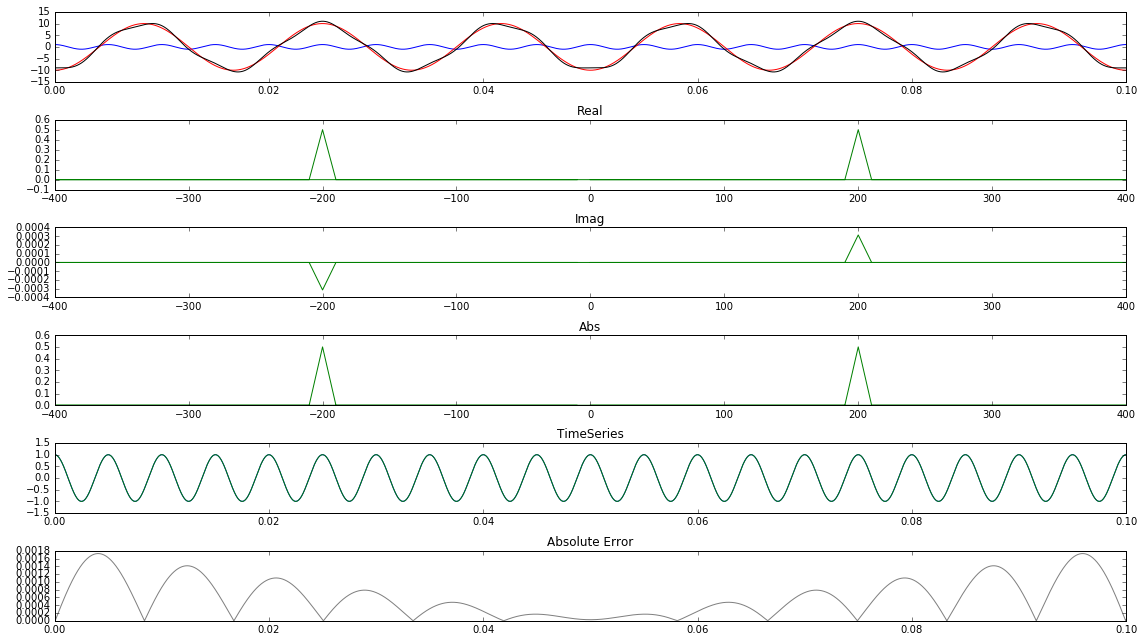

In [17]:
Discretization = FloatSlider(min=1.,max=10.,step=0.5,value=3.) #exponential increase of the number of signal samples
Noise_Signal_ratio = FloatSlider(min=-5,max=5.,step=0.5,value=1.) #Noise to Signal Ratio
Noise_phase = FloatSlider(min=-1.,max=1.,step=0.1,value=0.5) # Phase of the 60Hz compared to signal
PlotOpt_button = ToggleButtons(options=['Signal','Noise','Total','Filtered'],value = 'Signal') #Choose which spectrum to plot
start = 0.
end = 0.1
Amp = 1.
fs = 200.
fn = 60.

#blue: signal
#red: noise
#black: total
#green: filtered

def PowerlineNoise(dis,NAmpR,phin,Opt):
    
    fig, ax = plt.subplots(6,1,figsize=(16,9))
    ax = mkvc(ax)
    
    phin2=phin*np.pi
    dis2=int(10.**dis)
    t=deftime(start,end,dis2)
    dt = (t.max() - t.min())/float(t.size)
    freq = fftpack.fftfreq(t.size,dt)
    df = (freq.max() - freq.min())/float(freq.size) # timestep
    
    signal = defsignal(Amp,fs,0.,t)
    noise = defsignal(10.**NAmpR*Amp,fn,phin2,t)
    total = signal + noise
    
    Signal = dt*df*fftpack.fft(signal)
    Noise = dt*df*fftpack.fft(noise)
    Total = dt*df*fftpack.fft(total)
    
    
    SignalFilt=RemoveFreqFilter(fn,freq,Total)
    
    signalFilt_i=fftpack.ifft(SignalFilt)/(dt*df)
    

    ax[0].plot(t,signal,color='blue')
    ax[0].plot(t,noise,color='red')
    ax[0].plot(t,total,color='black')
    ax[0].set_xlim([t.min(), t.max()])
    
    ax[1].set_title('Real')
    ax[1].set_xlim([-2.*fs, 2.*fs])

    ax[2].set_title('Imag')
    ax[2].set_xlim([-2.*fs, 2.*fs])
    
    ax[3].set_title('Abs')
    ax[3].set_xlim([-2.*fs, 2.*fs])
     
    diff = abs(signalFilt_i-signal)
    
    ax[4].plot(t,signal,color='blue')
    ax[4].plot(t,signalFilt_i,color='green')
    ax[4].set_xlim([t.min(), t.max()])
    ax[4].set_title('TimeSeries')
    
    ax[5].plot(t,diff,color='gray')
    ax[5].set_xlim([t.min(), t.max()])
    ax[5].set_title('Absolute Error')
    
    
    
    if Opt=='Signal':
        ax[1].plot(freq,Signal.real,color='blue')
        ax[2].plot(freq,Signal.imag,color='blue')
        ax[3].plot(freq,np.abs(Signal),color='blue')
    elif Opt=='Noise':
        ax[1].plot(freq,Noise.real,color='red')
        ax[2].plot(freq,Noise.imag,color='red')
        ax[3].plot(freq,np.abs(Noise),color='red')
    elif Opt=='Total':
        ax[1].plot(freq,Total.real,color='black')
        ax[2].plot(freq,Total.imag,color='black')
        ax[3].plot(freq,np.abs(Total),color='black')
    elif Opt=='Filtered':
        ax[1].plot(freq,SignalFilt.real,color='green')
        ax[2].plot(freq,SignalFilt.imag,color='green')
        ax[3].plot(freq,np.abs(SignalFilt),color='green')


    #ax[4].plot(t,signal)
    #ax[4].set_xlim([t.min(), t.max()])
    #ax[4].plot(t,noise)
    #ax[4].plot(t,total)
    
    plt.tight_layout()
    
    
    
interact(PowerlineNoise,dis=Discretization,phin=Noise_phase,NAmpR=Noise_Signal_ratio,Opt=PlotOpt_button)

# Random noise

<function __main__.RandomNoise>

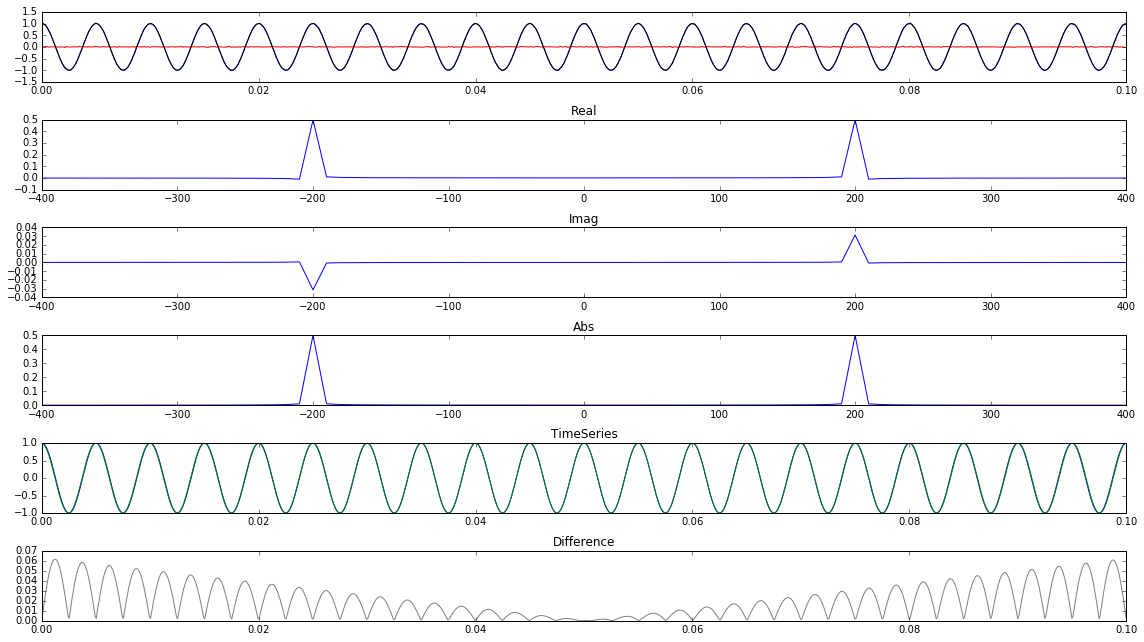

In [14]:
#Visualisation of the effect of a random noise
Discretization = FloatSlider(min=1.,max=10.,step=0.5,value=3.) #exponential increase of the number of signal samples
Noise_Signal_ratio = FloatSlider(min=-5,max=5.,step=0.5,value=-2.) #Noise to Signal Ratio
#Noise_phase = FloatSlider(min=-1.,max=1.,step=0.1,value=0.) # Phase of the 60Hz compared to signal
PlotOpt_button = ToggleButtons(options=['Signal','Noise','Total','Filtered'],value = 'Signal') #Choose which spectrum to plot
start = 0.
end = 0.1
Amp = 1.
fs = 200.
fn = 60.

#blue: signal
#red: noise
#black: total
#green: filtered

def RandomNoise(dis,NAmpR,Opt):
    
    fig, ax = plt.subplots(6,1,figsize=(16,9))
    ax = mkvc(ax)
    
    phin2=phin*np.pi
    dis2=int(10.**dis)
    t = deftime(start,end,dis2)
    dt = (t.max() - t.min())/float(t.size)
    freq = fftpack.fftfreq(t.size,dt)
    df = (freq.max() - freq.min())/float(freq.size) # timestep
    
    signal = defsignal(Amp,fs,0.,t)
    noise = 10.**NAmpR*Amp*np.random.normal(0., 1.,t.size)
    total = signal + noise
    
    Signal = dt*df*fftpack.fft(signal)
    Noise = dt*df*fftpack.fft(noise)
    Total = dt*df*fftpack.fft(total)
    
    
    SignalFilt=KeepFreqFilter(fs,freq,Total)
    
    #signalFilt_i=fftpack.ifftshift(fftpack.ifft(SignalFilt))/(dt*df)
    signalFilt_i=fftpack.ifft(SignalFilt)/(dt*df)
    

    ax[0].plot(t,signal,color='blue')
    ax[0].plot(t,noise,color='red')
    ax[0].plot(t,total,color='black')
    ax[0].set_xlim([t.min(), t.max()])
    
    ax[1].set_title('Real')
    ax[1].set_xlim([-2.*fs, 2.*fs])

    ax[2].set_title('Imag')
    ax[2].set_xlim([-2.*fs, 2.*fs])
    
    ax[3].set_title('Abs')
    ax[3].set_xlim([-2.*fs, 2.*fs])
     
    diff = abs(signalFilt_i-signal)
    
    ax[4].plot(t,signal,color='blue')
    ax[4].plot(t,signalFilt_i,color='green')
    ax[4].set_xlim([t.min(), t.max()])
    ax[4].set_title('TimeSeries')
    
    ax[5].plot(t,diff,color='gray')
    ax[5].set_xlim([t.min(), t.max()])
    ax[5].set_title('Difference')
    
    
    
    if Opt=='Signal':
        ax[1].plot(fftpack.fftshift(freq),fftpack.fftshift(Signal.real),color='blue')
        ax[2].plot(fftpack.fftshift(freq),fftpack.fftshift(Signal.imag),color='blue')
        ax[3].plot(fftpack.fftshift(freq),fftpack.fftshift(np.abs(Signal)),color='blue')
    elif Opt=='Noise':
        ax[1].plot(fftpack.fftshift(freq),fftpack.fftshift(Noise.real),color='red')
        ax[2].plot(fftpack.fftshift(freq),fftpack.fftshift(Noise.imag),color='red')
        ax[3].plot(fftpack.fftshift(freq),fftpack.fftshift(np.abs(Noise)),color='red')
    elif Opt=='Total':
        ax[1].plot(fftpack.fftshift(freq),fftpack.fftshift(Total.real),color='black')
        ax[2].plot(fftpack.fftshift(freq),fftpack.fftshift(Total.imag),color='black')
        ax[3].plot(fftpack.fftshift(freq),fftpack.fftshift(np.abs(Total)),color='black')
    elif Opt=='Filtered':
        ax[1].plot(fftpack.fftshift(freq),fftpack.fftshift(SignalFilt).real,color='green')
        ax[2].plot(fftpack.fftshift(freq),fftpack.fftshift(SignalFilt).imag,color='green')
        ax[3].plot(fftpack.fftshift(freq),fftpack.fftshift(np.abs(SignalFilt)),color='green')


    #ax[4].plot(t,signal)
    #ax[4].set_xlim([t.min(), t.max()])
    #ax[4].plot(t,noise)
    #ax[4].plot(t,total)
    
    plt.tight_layout()
    
    
    
interact(RandomNoise,dis=Discretization,NAmpR=Noise_Signal_ratio,Opt=PlotOpt_button)